# Случайные леса
__Суммарное количество баллов: 10__

В этом задании вам предстоит реализовать ансамбль деревьев решений, известный как случайный лес, применить его к публичным данным и сравнить его эффективность с ансамблем, предоставляемым библиотекой CatBoost.

In [18]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import random
import csv


### Задание 1 (3 балла)
Реализуем сам Random Forest. Идея очень простая: строим `n` деревьев, а затем берем модальное предсказание.

#### Параметры конструктора
`n_estimators` - количество используемых для предсказания деревьев.

Остальное - параметры деревьев.

#### Методы
`fit(X, y)` - строит `n_estimators` деревьев по выборке `X`.

`predict(X)` - для каждого элемента выборки `X` возвращает самый частый класс, который предсказывают для него деревья.

In [3]:
class RandomForestClassifier:
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1, max_features="auto", n_estimators=10):
        self.X = []
        self.y = []
        self.n_estimators = n_estimators
        self.trees = []
        self.OOB_error = 0
        
        for i in range(n_estimators):
            self.trees.append(DecisionTreeClassifier(max_depth=max_depth, 
                                                     min_samples_leaf=min_samples_leaf, 
                                                     max_features=max_features, 
                                                     criterion=criterion))  
    def fit(self, X, y):
        self.X = X
        self.y = y
        inds = []
        errors = []
        
        for j in range(self.n_estimators):
            X_n = []
            y_n = []
            for i in range(len(X)):
                inds.append(random.randint(0, len(X)-2))
                
            for i in inds:
                X_n.append(X[i])
                y_n.append(y[i]) 

            self.trees[j].fit(np.array(X_n), np.array(y_n))
            y_pred = self.trees[j].predict(np.array(X_n))
            errors.append(1-metrics.accuracy_score(y_n, y_pred))
            
        self.OOB_error = np.mean(errors)


    def predict(self, X):
        classes = []
        for i in range(self.n_estimators):
            for j in range(len(X)):
                classes.append(self.trees[i].predict([X[j]])[0])
        classes = np.array(classes)
        classes.shape = ((self.n_estimators, len(X)))
        res = []
        for j in range(len(classes[0])):
            ones = 0
            zeros = 0
            for i in range(len(classes)):
                if classes[i][j] == 1:
                    ones += 1
                else:
                    zeros += 1
            if ones > zeros:
                res.append(1)
            else:
                res.append(0)
                
        return res



### Задание 3 (3 балла)
Оптимизируйте по AUC на кроссвалидации (размер валидационной выборки - 20%) параметры своей реализации Random Forest: 

максимальную глубину деревьев из [2, 3, 5, 7, 10], количество деревьев из [5, 10, 20, 30, 50, 100]. 

Постройте ROC кривую (и выведите AUC и accuracy) для лучшего варианта.

Подсказка: можно построить сразу 100 деревьев глубины 10, а потом убирать деревья и
глубину.

In [42]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()
    
def read_cancer_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    f = open(path_to_csv, 'r')
    X = np.array([[]])
    y = np.array([[]])
    reader = csv.reader(f)
    for row in reader:
        list = [[]]
        label = 0
        for col in row:
            if col == 'label':
                break
            if col == 'M':
                label = 1
            if col != 'M' and col != 'B':
               list[0].append(float(col))

        if y[0].size == 0:
            y = np.array([label])
        else:
            y = np.append(y, [label])
        if X[0].size == 0:
            X = np.array(list)
        else:
            X = np.append(X, list, axis = 0)

    f.close()
    return X[:][:], y[1:]

def read_spam_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    f = open(path_to_csv, 'r')
    X = np.array([[]])
    y = np.array([[]])
    reader = csv.reader(f)
    k = 0
    for row in reader:
        if k == 0:
            k = 1
            continue
        list = [[]]
        for i in range(len(row)):
            if i != len(row)-1:
                list[0].append(float(row[i]))
            else:
                if y[0].size == 0:
                    y = np.array([int(row[i])])
                else:
                    y = np.append(y, [int(row[i])])

        if X[0].size == 0:
            X = np.array(list)
        else:
            X = np.append(X, list, axis = 0)

    f.close()
    return X[:][:], y[1:]

def train_test_split(X, y, ratio):
    # Возвращает X_train, y_train, X_test, y_test
    # X_train и X_test - массив векторов - две части массива X, разделенного в состветсви с коэффициентом ratio
    # y_train и y_test - соответствующие X_train и X_test метки классов
    X_train = np.array([[]])
    X_test = np.array([[]])
    y_train = np.array([])
    y_test = np.array([])
    trainlist = []
    testlist = []
    train = int(ratio*len(y))

    for i in range(train):
        tr = random.randint(0, len(y)-1)
        while tr in trainlist:
            tr = random.randint(0, len(y)-1)

        trainlist.append(tr)

    for i in range(0, len(y)):
        if i not in trainlist:
            testlist.append(i)

    X_train = X[trainlist][:]
    X_test = X[testlist][:]
    y_train = y[trainlist]
    y_test = y[testlist]

    return X_train, y_train, X_test, y_test

def get_accuracy(y_test, y_pred):
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    for i in range(len(y_test)):
        if (y_test[i] == 1) and (y_pred[i] == 1):
            TP += 1
        elif (y_test[i] == 0) and (y_pred[i] == 1):
            FP += 1
        elif (y_test[i] == 1) and (y_pred[i] == 0):
            FN += 1
        else:
            TN += 1
    return (TP + TN) / (TP + TN + FP + FN)

def train_test_split_cross(X, y, r, ind):
    p = np.random.permutation(len(y))
    X = X[p]
    y = y[p]
    len_ind = []
    samples = int(1 / r)
    for i in range(samples):
        if i == samples-1:
            len_ind.append(len(y) - int(len(y)*r)*(samples-1))
        else:
            len_ind.append(int(len(y)*r))
    X_test = []
    y_test = []
    X_train = []
    y_train = []
    
    prev = 0
    if ind != 0:
        for i in range(ind-1):
            prev += len_ind[i]

    curr = 0
    for i in range(len(len_ind)):
        if i == 0:
            curr = 0
        elif i == 1:
            curr = len_ind[0] 
        else:
            curr = 0
            for j in range(0, i-1):
                curr += len_ind[i-1]
        for j in range(len_ind[i]):
            if ind != i:
                #print(i, curr)
                X_train.append(X[curr + j])
                y_train.append(y[curr + j])
            else:
                X_test.append(X[prev + j])
                y_test.append(y[prev + j])
        if ind == i:        
            y_test = np.array(y_test)
            X_test = np.array(X_test)
            X_test.shape = ((len_ind[i], len(X[0])))
            
    curr = 0
    for i in range(len(len_ind)):
        if i != ind:
            curr += len_ind[i]
    X_train = np.array(X_train)
    X_train.shape = ((curr), len(X[0]))
    y_train = np.array(y_train)
    return X_test, y_test, X_train, y_train
            
def optimise(file, r = 0.2):
    if file == 'cancer.csv':
        X, y = read_cancer_dataset(file)
    if file == 'spam.csv':
        X, y = read_spam_dataset(file)
        
    depths = [10, 7, 5, 3, 2]
    nums = [100, 50, 30, 20, 10, 5]
    opt_depth = 10
    opt_depth = 100

    res_auc = 0
    res_depth = 0
    res_num = 0
    res_accuracy = 0
    
    
    for d in depths:
        for n in nums:
            auc = 0
            res_accuracy = 0
            for i in range(int(1/r)):           
                X_test, y_test, X_train, y_train = train_test_split_cross(X, y, 0.2, i)
                rforest = RandomForestClassifier(max_depth=d, n_estimators=n)
                rforest.fit(X_train, y_train)
                y_pred = rforest.predict(X_test)
                auc += metrics.roc_auc_score(y_test, y_pred)
                res_accuracy += get_accuracy(y_test, y_pred)
            auc /= int(1/r)
            res_accuracy /= int(1/r)
            if res_auc < auc:
                res_auc = auc
                res_depth = d
                res_num = n
    print('number of tres: ', res_num,
          '\nnumber of depth: ', res_depth,
          '\nauc: ', res_auc,
          '\naccuracy: ', res_accuracy)
 

In [ ]:
print('for cancer:')
optimise('cancer.csv')
print('\nfor spam:')
optimise('spam.csv')

for cancer:
number of tres:  10 
number of depth:  10 
auc:  0.9815622340022081 
accuracy:  0.9210195900461388

for spam:


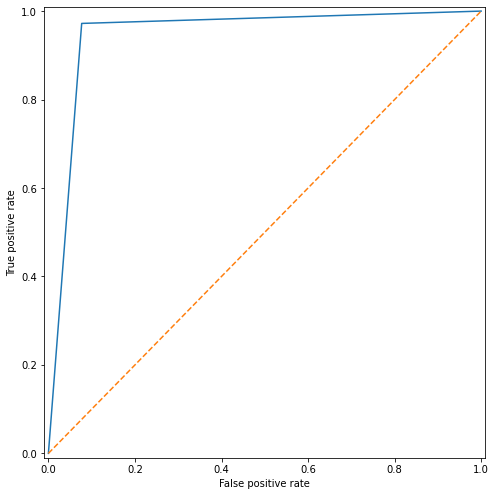

In [5]:
X, y = read_cancer_dataset('cancer.csv')
X_train, y_train, X_test, y_test   = train_test_split(X, y, ratio=0.2)
rfc = RandomForestClassifier(n_estimators=30, max_depth=10)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
plot = []       
for j in range(len(y_pred)):
        if y_pred[j] == 0:
            plot.append({0: 1, 1: 0})
        else:                
            plot.append({0: 0, 1: 1})
plot_roc_curve(y_test, plot)


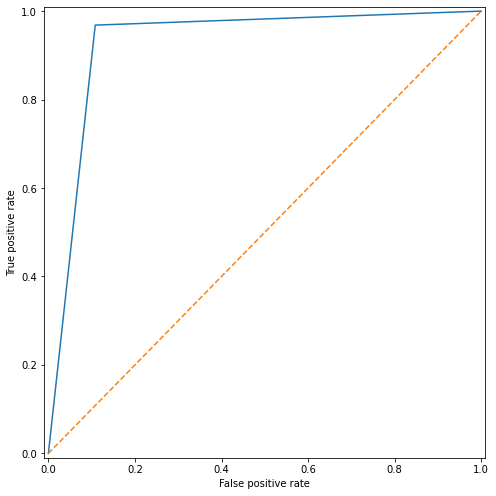

In [6]:
X, y = read_spam_dataset('spam.csv')
X_train, y_train, X_test, y_test   = train_test_split(X, y, ratio=0.2)
rfc = RandomForestClassifier(n_estimators=50, max_depth=10)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
plot = []       
for j in range(len(y_pred)):
        if y_pred[j] == 0:
            plot.append({0: 1, 1: 0})
        else:                
            plot.append({0: 0, 1: 1})
plot_roc_curve(y_test, plot)

### Задание 4 (3 балла)
Часто хочется понимать, насколько большую роль играет тот или иной признак для предсказания класса объекта. Есть различные способы посчитать его важность. Один из простых способов сделать это для Random Forest выглядит так:
1. Посчитать out-of-bag ошибку предсказания `err_oob` (https://en.wikipedia.org/wiki/Out-of-bag_error)
2. Перемешать значения признака `j` у объектов выборки (у каждого из объектов изменится значение признака `j` на какой-то другой)
3. Посчитать out-of-bag ошибку (`err_oob_j`) еще раз.
4. Оценкой важности признака `j` для одного дерева будет разность `err_oob_j - err_oob`, важность для всего леса считается как среднее значение важности по деревьям.

Реализуйте функцию `feature_importance`, которая принимает на вход Random Forest и возвращает массив, в котором содержится важность для каждого признака.

In [33]:
def feature_importance(rfc, X, y):
    err_oob = rfc.OOB_error
    err_oob_j = []
    
    for i in range(len(X[0])):
        inds = [j for j in range(len(X))]
        random.shuffle(inds)
        X_j = copy.deepcopy(X)
        
        for j in range(len(X)):
            X_j[j][i] = X[inds[j]][i]
        
        rfc.fit(X_j, y)
        err_oob_j.append(rfc.OOB_error)
        
    res = []
    for i in range(len(err_oob_j)):
        res.append(abs(err_oob - err_oob_j[i]))
        
    return res
        
    
        

def most_important_features(importance, names, k=20):
    # Выводит названия k самых важных признаков
    idicies = np.argsort(importance)[::-1][:k]
    return np.array(names)[idicies]

Протестируйте решение на простом синтетическом наборе данных. В результате должна получиться точность `1.0`, наибольшее значение важности должно быть у признака с индексом `4`, признаки с индексами `2` и `3`  должны быть одинаково важны, а остальные признаки - не важны совсем.

In [41]:
def synthetic_dataset(size):
    X = [(np.random.randint(0, 2), np.random.randint(0, 2), i % 6 == 3, 
          i % 6 == 0, i % 3 == 2, np.random.randint(0, 2)) for i in range(size)]
    y = [i % 3 for i in range(size)]
    return np.array(X), np.array(y)

X, y = synthetic_dataset(1000)
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X, y)
print("Accuracy:", np.mean(rfc.predict(X) == y))
print("Importance:", feature_importance(rfc, X, y))


Accuracy: 0.667
Importance: [0.0, 0.0, 0.16480003528359385, 0.1648970998664716, 0.2937762685098458, 0.0]


#### Что-то странное с accuracy

Проверьте, какие признаки важны для датасетов cancer и spam?

#### Cancer:

In [38]:
X, y = read_cancer_dataset('cancer.csv')
X_train, y_train, X_test, y_test   = train_test_split(X, y, ratio=0.2)
rfc = RandomForestClassifier(n_estimators=30, max_depth=10)
rfc.fit(X_train, y_train)
print("Accuracy:", np.mean(rfc.predict(X_test) == y_test))
print("Importance:", most_important_features(feature_importance(rfc, X, y),[i for i in range(len(X[0]))]))

Accuracy: 0.9320175438596491
Importance: [ 8 21  1  4 10 28  2 24 25 14 27 16 18 17 26 13 15  7  9 29]


#### Spam:

In [40]:

X, y = read_spam_dataset('spam.csv')
X_train, y_train, X_test, y_test   = train_test_split(X, y, ratio=0.2)
rfc = RandomForestClassifier(n_estimators=50, max_depth=10)
rfc.fit(X_train, y_train)
print("Accuracy:", np.mean(rfc.predict(X_test) == y_test))
print("Importance:", most_important_features(feature_importance(rfc, X, y),[i for i in range(len(X[0]))]))

Accuracy: 0.9331521739130435
Importance: [51  6 15 24 55 52 54 45 23  2 18 33 37 49 25 32 16 42 20 17]


### Задание 5 (1 балл)
В качестве аьтернативы попробуем CatBoost. 

Туториалы можно найти, например, [здесь](https://catboost.ai/docs/) и [здесь](https://github.com/catboost/tutorials/blob/master/python_tutorial.ipynb).

Также, как и реализованный ними RandomForest, примените его для наших датасетов.

In [39]:
X, y = read_cancer_dataset('cancer.csv')
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.2)
clf = CatBoostClassifier()
clf.fit(X_train, y_train)
print("Accuracy:", np.mean(clf.predict(X) == y))

Learning rate set to 0.004061
0:	learn: 0.6885595	total: 1.67ms	remaining: 1.67s
1:	learn: 0.6830361	total: 3.13ms	remaining: 1.56s
2:	learn: 0.6775212	total: 4.57ms	remaining: 1.52s
3:	learn: 0.6727919	total: 5.84ms	remaining: 1.45s
4:	learn: 0.6667221	total: 6.36ms	remaining: 1.27s
5:	learn: 0.6625307	total: 7.44ms	remaining: 1.23s
6:	learn: 0.6584947	total: 8.64ms	remaining: 1.23s
7:	learn: 0.6528242	total: 9.7ms	remaining: 1.2s
8:	learn: 0.6476889	total: 10.7ms	remaining: 1.18s
9:	learn: 0.6432807	total: 12.1ms	remaining: 1.2s
10:	learn: 0.6386655	total: 13.2ms	remaining: 1.19s
11:	learn: 0.6333674	total: 14.2ms	remaining: 1.17s
12:	learn: 0.6292367	total: 15.2ms	remaining: 1.16s
13:	learn: 0.6243655	total: 16.3ms	remaining: 1.15s
14:	learn: 0.6192087	total: 17.3ms	remaining: 1.13s
15:	learn: 0.6153229	total: 18.4ms	remaining: 1.13s
16:	learn: 0.6106185	total: 19.6ms	remaining: 1.14s
17:	learn: 0.6061640	total: 20.9ms	remaining: 1.14s
18:	learn: 0.6021120	total: 22ms	remaining: 1.1

178:	learn: 0.2317337	total: 187ms	remaining: 858ms
179:	learn: 0.2304483	total: 188ms	remaining: 858ms
180:	learn: 0.2291081	total: 194ms	remaining: 878ms
181:	learn: 0.2281249	total: 195ms	remaining: 878ms
182:	learn: 0.2271294	total: 196ms	remaining: 876ms
183:	learn: 0.2262629	total: 206ms	remaining: 912ms
184:	learn: 0.2253005	total: 207ms	remaining: 911ms
185:	learn: 0.2240657	total: 208ms	remaining: 911ms
186:	learn: 0.2231055	total: 209ms	remaining: 910ms
187:	learn: 0.2220270	total: 211ms	remaining: 910ms
188:	learn: 0.2207639	total: 212ms	remaining: 910ms
189:	learn: 0.2200169	total: 219ms	remaining: 934ms
190:	learn: 0.2188966	total: 220ms	remaining: 934ms
191:	learn: 0.2178870	total: 222ms	remaining: 934ms
192:	learn: 0.2170579	total: 224ms	remaining: 935ms
193:	learn: 0.2164949	total: 225ms	remaining: 934ms
194:	learn: 0.2159141	total: 226ms	remaining: 932ms
195:	learn: 0.2148111	total: 227ms	remaining: 931ms
196:	learn: 0.2137202	total: 228ms	remaining: 929ms
197:	learn: 

340:	learn: 0.1194883	total: 375ms	remaining: 725ms
341:	learn: 0.1189962	total: 377ms	remaining: 725ms
342:	learn: 0.1186624	total: 378ms	remaining: 724ms
343:	learn: 0.1183344	total: 379ms	remaining: 723ms
344:	learn: 0.1178965	total: 380ms	remaining: 721ms
345:	learn: 0.1175084	total: 381ms	remaining: 720ms
346:	learn: 0.1171509	total: 382ms	remaining: 719ms
347:	learn: 0.1168505	total: 383ms	remaining: 718ms
348:	learn: 0.1164475	total: 384ms	remaining: 717ms
349:	learn: 0.1160546	total: 385ms	remaining: 716ms
350:	learn: 0.1156770	total: 387ms	remaining: 715ms
351:	learn: 0.1152744	total: 388ms	remaining: 714ms
352:	learn: 0.1149798	total: 389ms	remaining: 713ms
353:	learn: 0.1144806	total: 391ms	remaining: 714ms
354:	learn: 0.1141540	total: 393ms	remaining: 714ms
355:	learn: 0.1137635	total: 394ms	remaining: 713ms
356:	learn: 0.1133200	total: 395ms	remaining: 712ms
357:	learn: 0.1127730	total: 396ms	remaining: 710ms
358:	learn: 0.1124216	total: 397ms	remaining: 709ms
359:	learn: 

515:	learn: 0.0706472	total: 561ms	remaining: 526ms
516:	learn: 0.0705450	total: 562ms	remaining: 525ms
517:	learn: 0.0704208	total: 563ms	remaining: 524ms
518:	learn: 0.0701712	total: 565ms	remaining: 523ms
519:	learn: 0.0700106	total: 566ms	remaining: 522ms
520:	learn: 0.0698292	total: 567ms	remaining: 521ms
521:	learn: 0.0696607	total: 568ms	remaining: 520ms
522:	learn: 0.0694912	total: 570ms	remaining: 519ms
523:	learn: 0.0693114	total: 573ms	remaining: 520ms
524:	learn: 0.0691692	total: 574ms	remaining: 519ms
525:	learn: 0.0690079	total: 575ms	remaining: 518ms
526:	learn: 0.0688513	total: 577ms	remaining: 518ms
527:	learn: 0.0686725	total: 578ms	remaining: 516ms
528:	learn: 0.0684412	total: 579ms	remaining: 515ms
529:	learn: 0.0681817	total: 580ms	remaining: 514ms
530:	learn: 0.0680126	total: 581ms	remaining: 513ms
531:	learn: 0.0678462	total: 582ms	remaining: 512ms
532:	learn: 0.0676985	total: 583ms	remaining: 511ms
533:	learn: 0.0675139	total: 585ms	remaining: 510ms
534:	learn: 

682:	learn: 0.0475908	total: 748ms	remaining: 347ms
683:	learn: 0.0474670	total: 749ms	remaining: 346ms
684:	learn: 0.0473664	total: 751ms	remaining: 345ms
685:	learn: 0.0472578	total: 752ms	remaining: 344ms
686:	learn: 0.0471604	total: 753ms	remaining: 343ms
687:	learn: 0.0470914	total: 756ms	remaining: 343ms
688:	learn: 0.0469823	total: 757ms	remaining: 342ms
689:	learn: 0.0468766	total: 758ms	remaining: 341ms
690:	learn: 0.0467900	total: 760ms	remaining: 340ms
691:	learn: 0.0467246	total: 761ms	remaining: 339ms
692:	learn: 0.0466190	total: 762ms	remaining: 338ms
693:	learn: 0.0464701	total: 763ms	remaining: 336ms
694:	learn: 0.0463830	total: 764ms	remaining: 335ms
695:	learn: 0.0463089	total: 765ms	remaining: 334ms
696:	learn: 0.0462224	total: 767ms	remaining: 333ms
697:	learn: 0.0461505	total: 768ms	remaining: 332ms
698:	learn: 0.0460885	total: 769ms	remaining: 331ms
699:	learn: 0.0459961	total: 770ms	remaining: 330ms
700:	learn: 0.0458939	total: 771ms	remaining: 329ms
701:	learn: 

847:	learn: 0.0351934	total: 936ms	remaining: 168ms
848:	learn: 0.0351258	total: 938ms	remaining: 167ms
849:	learn: 0.0350587	total: 940ms	remaining: 166ms
850:	learn: 0.0349668	total: 943ms	remaining: 165ms
851:	learn: 0.0349089	total: 944ms	remaining: 164ms
852:	learn: 0.0348319	total: 945ms	remaining: 163ms
853:	learn: 0.0347680	total: 948ms	remaining: 162ms
854:	learn: 0.0347095	total: 949ms	remaining: 161ms
855:	learn: 0.0346580	total: 950ms	remaining: 160ms
856:	learn: 0.0345947	total: 951ms	remaining: 159ms
857:	learn: 0.0345518	total: 953ms	remaining: 158ms
858:	learn: 0.0344946	total: 956ms	remaining: 157ms
859:	learn: 0.0344378	total: 957ms	remaining: 156ms
860:	learn: 0.0343920	total: 958ms	remaining: 155ms
861:	learn: 0.0343367	total: 959ms	remaining: 154ms
862:	learn: 0.0342674	total: 961ms	remaining: 152ms
863:	learn: 0.0342247	total: 962ms	remaining: 151ms
864:	learn: 0.0341883	total: 963ms	remaining: 150ms
865:	learn: 0.0341226	total: 964ms	remaining: 149ms
866:	learn: 